In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
from train_video import RateDistortionLoss
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
from utils import *
from torchvision import transforms
import math
import matplotlib.pyplot as plt

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "/data/maryam.sana/diffusers/examples/text_to_image/sd_mod"
#finetuned unet with jockey video
pipe_finetuned= StableDiffusionPipeline.from_pretrained(model_path)
pipe_finetuned = pipe_finetuned.to("cuda")

Loading pipeline components...: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.06it/s]


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img_path = 'data/custom_data/train/img00002.png'
image = Image.open(img_path)
print('size:', image.size) 
image_resized = image.resize((512,512))

size: (1920, 1080)


In [4]:
def psnr(a: torch.Tensor, b: torch.Tensor, max_val: int = 255) -> float:
    return 20 * math.log10(max_val) - 10 * torch.log10((a - b).pow(2).mean())

In [5]:
def prepare_latents(image,vae_encoder): 
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    latents = vae_encoder.encode(image_tensor.to('cuda'))
    latents = latents.latent_dist.sample()
    return latents

In [6]:
def decode_pred(pred, vae_encoder,pipe): 
    img = vae_encoder.decode(pred,return_dict=False)[0].detach()
    output = pipe.image_processor.postprocess(img,output_type='pil')
    return output[0]

In [7]:
def get_unet_pred(latents, t,prompt, pipe):
    latent_model_input = latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(prompt,'cuda',1,False)
    noise_pred = pipe.unet(latent_model_input,t,encoder_hidden_states=prompt_embeds,return_dict=False)[0]
    print('unet pred shape: ', noise_pred.shape)
    return noise_pred

In [16]:
## psnr experiment 

post_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor()
])
image_tensor = post_transform(image)
noise_std = 0.5  # This value can be adjusted based on your specific needs
noise = torch.randn_like(image_tensor) * noise_std
noisy_image = image_tensor + noise

print('psnr : ', psnr(image_tensor,image_tensor).item())
print('psnr : ', psnr(image_tensor,noisy_image).item())


psnr :  inf
psnr :  54.155357360839844


unet pred shape:  torch.Size([1, 4, 64, 64])


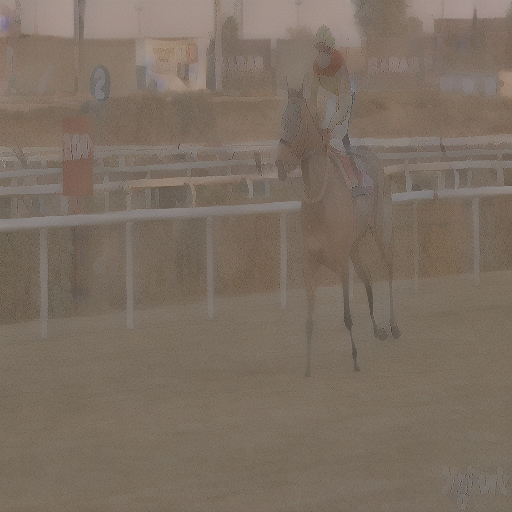

In [9]:
vae = pipe_finetuned.vae
latents = prepare_latents(image, vae)
prompt = "horse on grassy field with jockey"
t = 2
unet_pred = get_unet_pred(latents,t,prompt,pipe_finetuned)
reconst = decode_pred(unet_pred, vae,pipe_finetuned)
reconst

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.35it/s]


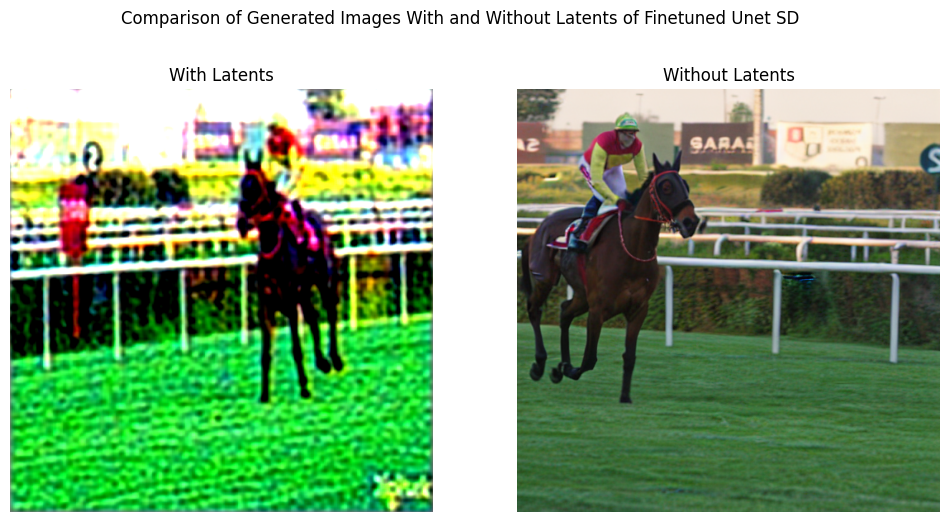

In [12]:
pred_with_latents = pipe_finetuned(prompt="horse on grassy field with jockey", height=512, width=512,latents=latents).images[0]
pred = pipe_finetuned(prompt="horse on grassy field with jockey", height=512, width=512).images[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image generated with latents on the first subplot
ax1.imshow(pred_with_latents)
ax1.set_title("With Latents")
ax1.axis('off')  # Turn off axis

# Display the image generated without latents on the second subplot
ax2.imshow(pred)
ax2.set_title("Without Latents")
ax2.axis('off')  # Turn off axis

# Add an overall title
plt.suptitle("Comparison of Generated Images With and Without Latents of Finetuned Unet SD")

# Show the plot
plt.show()

In [11]:
# finetuned PSNR RESULTS 
pred_l_tensor = post_transform(pred_with_latents).to('cpu').squeeze(0)
pred_tensor = post_transform(pred).to('cpu').squeeze(0)
orig_img = post_transform(image)

print('with latent: ',psnr(orig_img,pred_l_tensor).item())
print('without latent:', psnr(orig_img,pred_tensor).item())

with latent:  60.41960525512695
without latent: 61.011451721191406


In [13]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler,UniPCMultistepScheduler

torch_device = "cuda"

vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae", use_safetensors=True).to(torch_device)
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    model_path, subfolder="text_encoder", use_safetensors=True
).to(torch_device)
unet = UNet2DConditionModel.from_pretrained(
    model_path, subfolder="unet", use_safetensors=True
).to(torch_device)
scheduler = UniPCMultistepScheduler.from_pretrained(model_path, subfolder="scheduler")


In [14]:
prompt = ["horse on grassy field with jockey"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=torch_device )  # Place the generator on the CUDA device
generator.manual_seed(0) 
batch_size = len(prompt)

In [15]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [16]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [17]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [18]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device='cuda',
)
latents = latents * scheduler.init_noise_sigma
orig_image = a.to('cpu')

In [26]:
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
img_latents = vae.encode(image_tensor.to('cuda'))
img_latents = img_latents.latent_dist.sample()
noise_std = 0.1  # This value can be adjusted based on your specific needs
noise = torch.randn_like(img_latents) * noise_std
img_latents = img_latents + noise
img_latents = img_latents * scheduler.init_noise_sigma

In [20]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)
# latents = img_latents
def get_generated_images(latents):
    generated = []
    for i,t in enumerate(tqdm(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
        if i%10==0:
            latentsz = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(latentsz).sample
                img = image.to('cpu')
                print('psnr:', psnr(orig_image,img.squeeze(0)))
            
            image = (image / 2 + 0.5).clamp(0, 1).squeeze()
            image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
            image = Image.fromarray(image)      
            generated.append(image) 
            
    return generated,latents

generated ,l= get_generated_images(latents)

  1%|▊                                                                             | 1/100 [00:00<00:32,  3.05it/s]

psnr: tensor(49.5472)


 12%|█████████▏                                                                   | 12/100 [00:04<00:16,  5.36it/s]

psnr: tensor(49.7667)


 22%|████████████████▉                                                            | 22/100 [00:05<00:12,  6.43it/s]

psnr: tensor(50.0336)


 32%|████████████████████████▋                                                    | 32/100 [00:07<00:10,  6.44it/s]

psnr: tensor(50.4006)


 42%|████████████████████████████████▎                                            | 42/100 [00:08<00:09,  6.40it/s]

psnr: tensor(50.8886)


 52%|████████████████████████████████████████                                     | 52/100 [00:10<00:07,  6.37it/s]

psnr: tensor(51.4954)


 62%|███████████████████████████████████████████████▋                             | 62/100 [00:11<00:05,  6.35it/s]

psnr: tensor(52.1920)


 72%|███████████████████████████████████████████████████████▍                     | 72/100 [00:13<00:04,  6.35it/s]

psnr: tensor(52.9379)


 82%|███████████████████████████████████████████████████████████████▏             | 82/100 [00:14<00:02,  6.37it/s]

psnr: tensor(53.7174)


 92%|██████████████████████████████████████████████████████████████████████▊      | 92/100 [00:16<00:01,  6.38it/s]

psnr: tensor(54.5084)


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


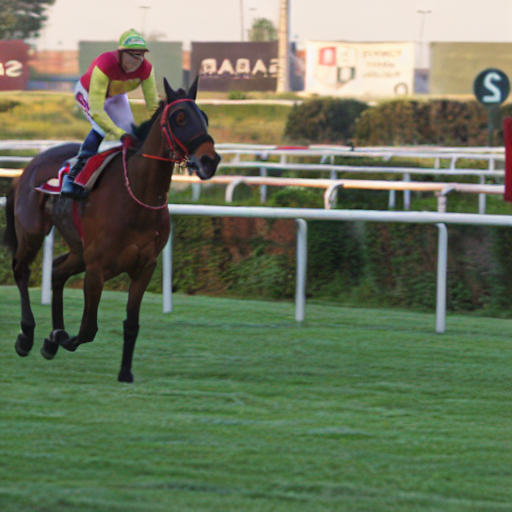

In [45]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * l
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

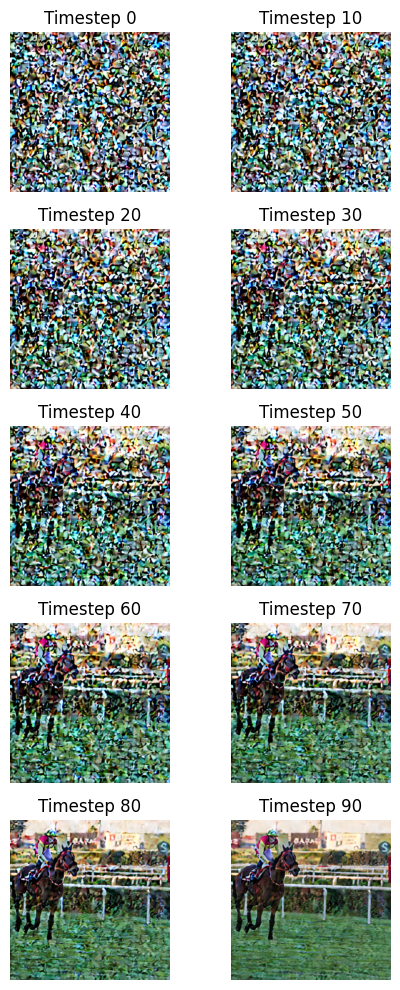

In [23]:
timesteps = [i * 10 for i in range(11)]

# Generate images for all specified timesteps
images = generated

# Create a figure with a 5x2 grid of axes
fig, axes = plt.subplots(5, 2, figsize=(5, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display each image in its respective subplot
for ax, img, t in zip(axes, images, timesteps):
    ax.imshow(img, cmap='gray')  # Assuming images are in grayscale for simplicity
    ax.set_title(f"Timestep {t}")
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()